In [1]:
!pip install scikit-learn pandas matplotlib seaborn --quiet

import pandas as pd, seaborn as sns, numpy as np
url = ("https://raw.githubusercontent.com/IBM/"
       "telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")
df = pd.read_csv(url)
print(df.shape); df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [19]:
# Fix TotalCharges (blank → NaN → numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes':1, 'No':0})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = X.select_dtypes('number').columns.tolist()
cat_cols = X.select_dtypes('object').columns.tolist()

pipe = Pipeline([
    ('prep', ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])),
    ('clf',  Pipeline(steps=[('model',
           __import__('sklearn').linear_model.LogisticRegression(max_iter=1000))]))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=42)


In [20]:
pipe.fit(X_train, y_train)
probs = pipe.predict_proba(X_test)[:,1]
preds = (probs >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
print("Accuracy:", round(accuracy_score(y_test, preds)*100,2), "%")
print("F1-Score:", round(f1_score(y_test, preds)*100,2))
print("ROC AUC :", round(roc_auc_score(y_test, probs),3))


Accuracy: 80.38 %
F1-Score: 60.8
ROC AUC : 0.836


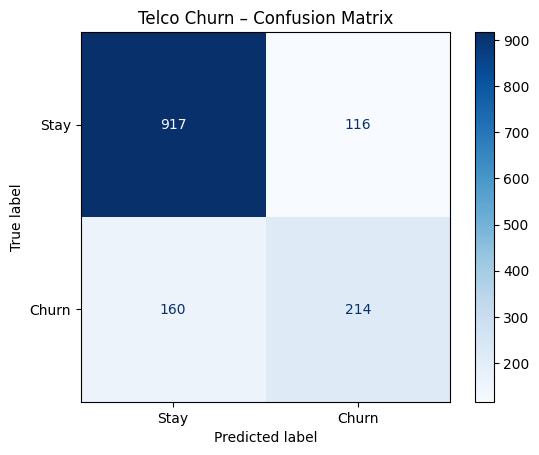

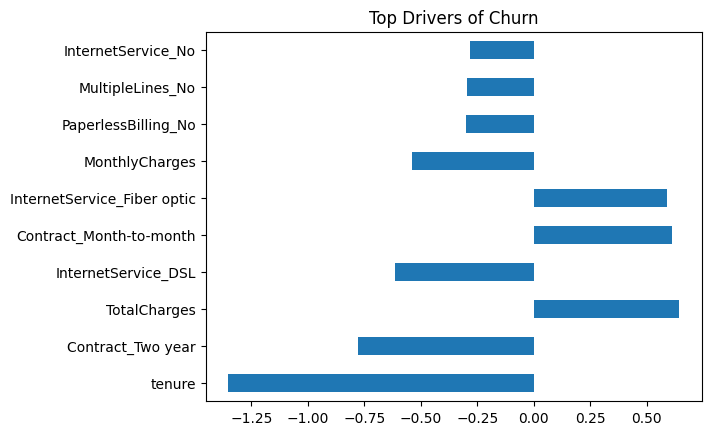

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    y_test, preds, display_labels=['Stay','Churn'], cmap='Blues')
plt.title("Telco Churn – Confusion Matrix"); plt.show()

# Get top 10 logistic coefficients for business insight
model = pipe.named_steps['clf'].named_steps['model']
ohe   = pipe.named_steps['prep'].named_transformers_['cat']
feat_names = num_cols + list(ohe.get_feature_names_out(cat_cols))
coef = pd.Series(model.coef_[0], index=feat_names).sort_values(key=abs, ascending=False)
coef.head(10).plot.barh(); plt.title("Top Drivers of Churn"); plt.show()


In [22]:
df_out = df.copy()
df_out['ChurnPred'] = pipe.predict(X)
df_out['ChurnProb'] = pipe.predict_proba(X)[:,1].round(3)
df_out.to_csv("telco_churn_clean.csv", index=False)
print("✅ Saved telco_churn_clean.csv")


✅ Saved telco_churn_clean.csv
